# Classify the Test Set

In this notebook we used the previously trained Gradient Boosting Decision Tree (see notebook [6_train_classifier]() for how to train it) to classify the test set. Additionally, we show some performance metrics.

#### Index<a name="index"></a>
1. [Import Packages](#imports)
2. [Test Set Features](#testFeatures)
    1. [Preprocess Dataset](#preprocess)
        1. [Load Original Dataset](#loadData)
        2. [Preprocess Light Curves](#preprocess)
        3. [Save Processed PlasticcData](#saveData)
    2. [Extract Features](#features)
        1. [Fit Gaussian Processes](#gps)
        2. [Wavelet Decomposition](#waveletDecomp)
        3. [Include Redshift Information](#addZ)
        4. [Save the Features](#saveFeatures)
3. [Load Classifier](#loadClassifier)
4. [Classify Test Set](#classify)
5. [Performance](#performance) <font color=salmon>(Optional)</font>
    1. [Metrics](#metrics)
    2. [Confusion Matrix](#cm)
    3. [ROC Curves](#roc)
    4. [Recall and Precision](#recallPrecision)
        1. [Recall plot](#recall)
        2. [Precision plot](#precision)

## 1. Import Packages<a name="imports"></a>

In [1]:
import os
import pickle
import sys
import time

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

In [3]:
from snmachine import snclassifier, gps, snfeatures, analysis
from utils.plasticc_pipeline import create_folder_structure, get_directories, load_dataset
from utils.plasticc_utils import plot_confusion_matrix, plot_roc_curve

No module named 'pymultinest'

                PyMultinest not found. If you would like to use, please install
                Mulitnest with 'sh install/multinest_install.sh; source
                install/setup.sh'
                


In [4]:
%config Completer.use_jedi = False  # enable autocomplete

#### Aestetic settings

In [5]:
sns.set(font_scale=1.5, style="ticks")

## 2. Test Set Features<a name="testFeatures"></a>

Before classifying the test set events, we need to obtain their features. 

### 2.1. Preprocess Dataset<a name="preprocess"></a>

We start by preprocessing the test set similarly to what we did to the training set in [2_preprocess_data]().

#### 2.1.1. Load Original Dataset<a name="loadData"></a>

First, **write** the path to the dataset folder `folder_path`.

In [11]:
folder_path = '../snmachine/example_data'

Then, **write** in `data_file_name` the name of the file where your dataset is saved.

In this notebook we use the test set created in [1_load_data]().

In [12]:
data_file_name = 'example_test_dataset.pckl'

Load the dataset.

In [13]:
data_path = os.path.join(folder_path, data_file_name)
dataset = load_dataset(data_path)

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x7f439930ecd0>


If the features were already calculated, jump to [2.2.5. Load the Features](#loadFeatures).

#### 2.1.2. Preprocess light curves<a name="preprocess"></a>

**Write** the maximum duration of the gap to allowed in the light curves, `max_gap_length`. Note that this value *must* be the same as the one used for the training set.

In [14]:
max_gap_length = 50

In [15]:
dataset.remove_gaps(max_gap_length*2, verbose=True)
dataset.remove_gaps(max_gap_length*2, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)
dataset.remove_gaps(max_gap_length, verbose=True)

The longest event is 13926017 and its length is 1094.06 days.
The longest event is 13704710 and its length is 882.75 days.
The longest event is 10246631 and its length is 874.62 days.
The longest event is 6152283 and its length is 629.58 days.
The longest event is 1028147 and its length is 276.54 days.


In [16]:
print(f'The longest processed light curve has {dataset.get_max_length():.2f} days.')

The longest processed light curve has 276.54 days.


#### 2.1.3. Save Processed PlasticcData<a name="saveData"></a>

Now, **chose** a path to save the PlasticcData instance created (`folder_path_to_save`) and the name of the file (`file_name`).

In [17]:
folder_path_to_save = folder_path
file_name = data_file_name[:-5]+'_gapless50.pckl'
file_name

'example_test_dataset_gapless50.pckl'

In [18]:
with open(os.path.join(folder_path_to_save, file_name), 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

### 2.2. Extract Features<a name="features"></a>

Here we mostly repeat the steps shown in [5_feature_extraction]().

#### 2.2.1. Fit Gaussian Processes<a name="gps"></a>

First **write** the path to the folder where the GP files will be/were saved (`path_saved_gps`). Similarly to previous notebooks, you can opt:

**<font color=Orange>A1)</font>** Obtain GP path from folder structure.

If you created a folder structure, you can obtain the path from there. **Write** the name of the folder in `analysis_name`. 

In [19]:
analysis_name = file_name[:-5]
analysis_name

'example_test_dataset_gapless50'

Create the folder structure, if needed.

In [20]:
create_folder_structure(folder_path, analysis_name)

Obtain the required GP path.

In [21]:
directories = get_directories(folder_path, analysis_name) 
path_saved_gps = directories['intermediate_files_directory']

**<font color=Orange>A2)</font>** Directly **write** where you saved the GP files.

```python
path_saved_gps = os.path.join(folder_path, data_file_name[:-5])
```

**<font color=Orange>B)</font>** **Choose**:
- `t_min`: minimim time to evaluate the Gaussian Process Regression at.
- `t_max`: maximum time to evaluate the Gaussian Process Regression at.
- `gp_dim`: dimension of the Gaussian Process Regression. If  `gp_dim` is 1, the filters are fitted independently. If `gp_dim` is 2, the Matern kernel is used to fit light curves both in time and wavelength.
- `number_gp`: number of points to evaluate the Gaussian Process Regression at.
- `number_processes`: number of processors to use for parallelisation (**<font color=green>optional</font>**).

*Note* that all the above parameters with the exception of `number_processes` *must* be the same as the ones used for the training set.

In [22]:
t_min = 0
t_max = 277

gp_dim = 2
number_gp = 276
number_processes = 1

In [23]:
gps.compute_gps(dataset, number_gp=number_gp, t_min=t_min, t_max=t_max, 
                gp_dim=gp_dim, output_root=path_saved_gps, 
                number_processes=number_processes)

Performing Gaussian process regression.
Models fitted with the Gaussian Processes values.
Time taken for Gaussian process regression: 324.54s.


#### 2.2.2. Wavelet Decomposition<a name="waveletDecomp"></a>

Now, we do a wavelet decomposition of the test set events and project them into the feature space obtained with the training set. First, **write** in `saved_test_wavelets_path`  the path to the folder where to save the wavelets. Then, **write** in `path_saved_eigendecomp` the path to the folder where the training set eigendecomposition was saved. 

In [24]:
saved_test_wavelets_path = directories['intermediate_files_directory']
path_saved_eigendecomp = directories['analysis_directory']+'/../example_dataset_aug/wavelet_features'

Additionally, **write** the path to the folder where to save the reduced wavelets (`path_saved_reduced_wavelets`) and **choose** the number of PCA components to keep (`number_comps`). *Note* that this value *must* be the same as the one used to obtain the training set features.

In [25]:
path_saved_reduced_wavelets = directories['features_directory']
number_comps = 40

Perform the wavelet decomposition and project previously calculated wavelet features onto a lower dimensional space.

In [26]:
wf = snfeatures.WaveletFeatures(output_root=saved_test_wavelets_path)

test_reduced_wavelet_features = wf.compute_reduced_features(
    dataset, number_comps=number_comps, 
    path_saved_eigendecomp = path_saved_eigendecomp,
    **{'wavelet_name': 'sym2', 'number_decomp_levels': 2})

The wavelet used is sym2.
Each passband is decomposed in 2 levels.
Performing wavelet decomposition.
Time taken for wavelet decomposition: 51.51s.
Dimensionality reduced feature space with 40 components.


#### 2.2.3. Include Redshift Information<a name="addZ"></a>

**Include** any other features that was used to train the classifier.

In [27]:
features = test_reduced_wavelet_features.copy()  # only the wavelet features

metadata = dataset.metadata
features['hostgal_photoz'] = metadata.hostgal_photoz.values.astype(float)
features['hostgal_photoz_err'] = metadata.hostgal_photoz_err.values.astype(float)

#### 2.2.4. Save the Features<a name="saveFeatures"></a>

**Write** in `saved_features_path` the path to the folder where to save the final set of features.

In [28]:
path_saved_features = directories['features_directory']

In [29]:
features.to_pickle(os.path.join(path_saved_features, 'features.pckl'))

#### 2.2.5. Load the Features<a name="loadFeatures"></a> <font color=salmon>(Optional)</font>

If you jumped to here, **write** in `analysis_name` the name of the analysis.

In [30]:
analysis_name = 'example_test_dataset_gapless50'

In [31]:
directories = get_directories(folder_path, analysis_name) 
path_saved_features = directories['features_directory']

In [32]:
data_path = os.path.join(folder_path, analysis_name+'.pckl')
dataset = load_dataset(data_path)  # gapless dataset

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x7f439711b810>


In [33]:
features = pd.read_pickle(os.path.join(path_saved_features, 'features.pckl')) 

## 3. Load Classifier<a name="loadClassifier"></a>

First, **write** in `path_saved_classifier` the path to the folder that contains the trained classifier instance. The classifier was trained and saved in [6_train_classifier](). Additionally, **write** in `classifier_name` the name under which the classifier was saved.

In [34]:
path_saved_classifier = directories['analysis_directory']+'/../example_dataset_aug/classifications'
classifier_name = 'our_classifier.pck'

Load classifier instance.

In [35]:
with open(os.path.join(path_saved_classifier, classifier_name), 'rb') as input:
    classifier_instance = pickle.load(input)

Obtain the classifier.

In [36]:
classifier = classifier_instance.classifier

## 4. Classify Test Set<a name="classify"></a>

Compute the predicted class (`y_pred`) and the probability of belonging to each different class (`y_probs`). Note that the predicted class is the one whose probability of belong is highest.

In [37]:
y_pred_test = classifier.predict(features)
y_probs_test = classifier.predict_proba(features)

## 5. Performance<a name="performance"></a> <font color=salmon>(Optional)</font>

If we know the true class label of each event we can calculate the performance of the classifier. Otherwise, our predictions are saved in `y_pred_test` and `y_probs_test`.

In this example we know the true class labels.

In [38]:
data_labels = dataset.metadata.true_target  # class label of each event

### 5.1. Metrics<a name="metrics"></a>

We start by computing the Area under the ROC Curve (AUC) and the PLAsTiCC logloss. For that, choose which class to consider as *positive* (the other classes will be considered *negative*). Then, **write** in `which_column` the column that corresponds to that class. Note that the class order is accessed through the classifier.

In [39]:
classifier._classes

array([42, 62, 90])

In [40]:
which_column = 2  # we are interested in SN Ia vs others

Obtain the metrics.

In [41]:
classifier.which_column = which_column
auc_test = snclassifier.auc_score(classifier=classifier, X_features=features, 
                                  y_true=data_labels, which_column=which_column)
logloss_test = snclassifier.logloss_score(classifier=classifier, X_features=features, 
                                          y_true=data_labels)
print('{:^10} {:^10} {:^10}'.format('', 'AUC', 'Logloss'))
print('{:^10} {:^10.3f} {:^10.3f}'.format('test', auc_test, logloss_test))

              AUC      Logloss  
   test      0.652      -1.379  


Check how many events we correctly classified.

In [42]:
is_pred_right = y_pred_test == data_labels
np.sum(is_pred_right)

2711

### 5.2. Confusion Matrix<a name="cm"></a>

Now, plot the confusion matrix.

Confusion matrix normalised by true class.


array([[0.24829932, 0.19614512, 0.55555556],
       [0.14285714, 0.27018634, 0.58695652],
       [0.16815374, 0.08167467, 0.75017159]])

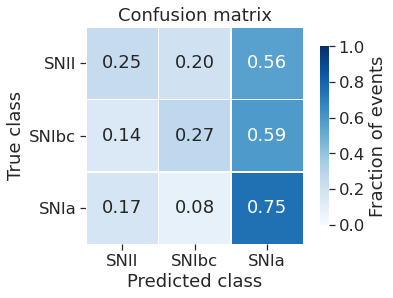

In [43]:
title = 'Confusion matrix'
analysis.plot_confusion_matrix(data_labels, y_pred_test, normalise='accuracy', title=title,
                               dict_label_to_real=analysis.dict_label_to_real_plasticc)

### 5.3. ROC Curves<a name="roc"></a>

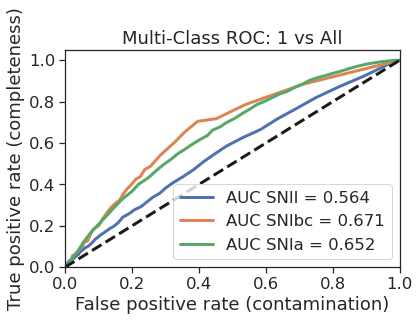

In [44]:
analysis.plot_classifier_roc_curve(data_labels, y_probs_test,
                                   dict_label_to_real=analysis.dict_label_to_real_plasticc)

### 5.4. Recall and Precision<a name="recallPrecision"></a>

First we create some auxiliary variables.

In [45]:
is_true_snii = data_labels == 42
is_true_snibc = data_labels == 62
is_true_snia = data_labels == 90

is_pred_snii = y_pred_test == 42
is_pred_snibc = y_pred_test == 62
is_pred_snia = y_pred_test == 90

# Use the same class order for the two lists below
is_true_type_list = [is_true_snia, is_true_snibc, is_true_snii] 
is_pred_type_list = [is_pred_snia, is_pred_snibc, is_pred_snii]

As an example, we will plot the recall and precision as a function of the light curve length.

We start by calculating the light curve length for all test set events.

In [46]:
lc_length = analysis.compute_lc_length(dataset)
quantity = lc_length

**Choose** bins for the plot and whether or not to plot the values in the middle of the bins. Additionally, to consider only a subset of events, **mask** those events in `extra_subset`. If `extra_subset = True`, all the events are used.

In [47]:
bins = np.linspace(0, 280, 6) 
use_mid_bins = True  # plot using the middle of the bins
extra_subset = True  # use all events

**Write** in `sn_order` an ordered list of the names of the classes. This should correspond to the class order used in `is_true_type_list`. Additionally, you can provide the colours with which to plot the classes results.

In [48]:
sn_order = ['SN Ia', 'SN Ibc', 'SN II']
diverg_color = sns.color_palette("Set2", 3, desat=1)
sn_colors = [diverg_color[2], diverg_color[1], diverg_color[0]]

#### 5.4.1. Recall plot<a name="recall"></a>

Start by calculating the recall and bootstrapped confidence intervals. Then, plot the figure.

In [49]:
recall_s, boot_recall_ci, number_in_bin_s = analysis.compute_recall_values(
    quantity=quantity, bins=bins, is_pred_right=is_pred_right, 
    use_mid_bins=use_mid_bins, is_true_type_list=is_true_type_list)

Time taken to compute the recall values: 0.38s.


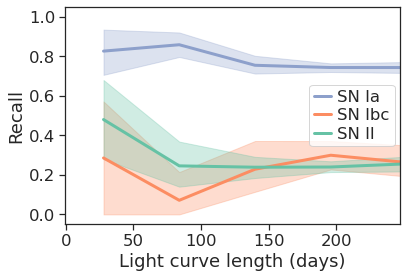

In [50]:
if use_mid_bins:
    mid_bins = (bins[:-1]+bins[1:])/2
    show_bins = mid_bins
else:
    show_bins = bins

x_label = 'Light curve length (days)'
x_min, x_max = -.5, 247

analysis.plot_sne_has_something(
    something_s=recall_s, boot_has_something_ci=boot_recall_ci,
    bins=show_bins, is_true_type_list=is_true_type_list, 
    sn_order=sn_order, **{'colors': sn_colors})
plt.ylabel('Recall')
plt.xlabel(x_label)
plt.xlim(x_min, x_max) 
plt.ylim(-0.05, 1.05)
plt.legend(handletextpad=.4, borderaxespad=.3, handlelength=1,
           labelspacing=.2, borderpad=.3, columnspacing=.4)

#### 5.4.2. Precision plot<a name="precision"></a>

Start by calculating the precision and bootstrapped confidence intervals. Then, plot the figure.

In [51]:
precision_s, boot_precision_ci, number_in_bin_s = analysis.compute_precision_values(
    quantity=quantity, bins=bins, is_pred_right=is_pred_right, 
    use_mid_bins=use_mid_bins, is_pred_type_list=is_pred_type_list)

Time taken to compute the precision values: 0.37s.


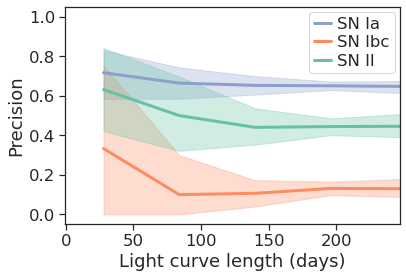

In [52]:
if use_mid_bins:
    mid_bins = (bins[:-1]+bins[1:])/2
    show_bins = mid_bins
else:
    show_bins = bins

x_label = 'Light curve length (days)'
x_min, x_max = -.5, 247

analysis.plot_sne_has_something(
    something_s=precision_s, boot_has_something_ci=boot_precision_ci,
    bins=show_bins, is_true_type_list=is_true_type_list, 
    sn_order=sn_order, **{'colors': sn_colors})
plt.ylabel('Precision')
plt.xlabel(x_label)
plt.xlim(x_min, x_max) 
plt.ylim(-0.05, 1.05)
plt.legend(handletextpad=.4, borderaxespad=.3, handlelength=1,
           labelspacing=.2, borderpad=.3, columnspacing=.4)

[Go back to top.](#index)